### IMGT mAb-db
This notebook scores the IMGT-mAb db sequences (used by Prihoda et al. and Marks et al.) and compares
the results of numbering / scoring with AntPack / SAM with those of other tools.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from antpack import SingleChainAnnotator, SequenceScoringTool
from antpack.constants.scoring_constants import scoring_constants as sconstants

aligner = SingleChainAnnotator(chains=["H", "K", "L"], scheme = "imgt")

if "notebooks" in os.getcwd():
    current_dir = os.path.join(os.getcwd(), "..", "..")

score_tool = SequenceScoringTool(normalization = "training_set_adjust")

os.chdir(current_dir)
tt_dir = [f for f in os.listdir() if f.startswith("train_test_data_immunogenicity")]
if len(tt_dir) != 1:
    raise ValueError("Data not downloaded yet, or multiple versions of data downloaded.")

tt_dir = tt_dir[0]

if "imgt_test_data" not in os.getcwd():
    os.chdir(os.path.join(current_dir, tt_dir, "imgt_test_data"))
    imgt_labels = pd.read_csv("imgt_mab_db.tsv", sep="\t")
    os.chdir(current_dir)
    

if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources", "imgt_mab_db_scores"))

label_dict = {str(k):v for (k,v) in zip(imgt_labels["INN_Number"].tolist(), imgt_labels["Species"].tolist())}

Load the AbNativ and Hu-mAb scores...

In [2]:
if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources", "imgt_mab_db_scores"))

abnativ_dict = {}
for f in os.listdir():
    if f.startswith("abnativ_imgt"):
        print(f)
        with open(f, "r") as fh:
            _ = fh.readline()
            for l in fh:
                seqid = l.split(",")[1].split("_")[0]
                seqscore = float(l.split(",")[4])
                if seqid in abnativ_dict:
                    abnativ_dict[seqid] = np.mean([seqscore, abnativ_dict[seqid]])
                else:
                    abnativ_dict[seqid] = seqscore

humab_dict = {}
for f in os.listdir():
    if f.startswith("humab_imgt"):
        print(f)
        with open(f, "r") as fh:
            _ = fh.readline()
            for l in fh:
                seqid = l.split("\t")[0].split("_")[0]
                seqscore = float(l.strip().split("\t")[1])
                if seqid in humab_dict:
                    humab_dict[seqid] = np.min([seqscore, humab_dict[seqid]])
                else:
                    humab_dict[seqid] = seqscore

abnativ_imgt_scores_KAPPA.csv
abnativ_imgt_scores_LAMBDA.csv
abnativ_imgt_scores_HEAVY.csv
humab_imgt


Load the BioPhi scores...

In [3]:
biophi_scores = pd.read_csv("imgt_mab_db_oasis.txt", delimiter=",")
biophi_dict = {}

for mab, percentile, identity in zip(biophi_scores.Antibody.tolist(),
                                     biophi_scores["OASis Percentile"].tolist(),
                                     biophi_scores["OASis Identity"].tolist()):
    seqid = mab.split("_")[0]
    score = identity
    if seqid in biophi_dict:
        biophi_dict[seqid] = np.mean([identity, biophi_dict[seqid]])
    else:
        biophi_dict[seqid] = identity

Now load and number / score the sequences with AntPack.

In [4]:
from Bio import SeqIO
cat_score_dict = {}
no_cdr_dict = {}
testing_dict = {"seq":[], "species":[], "lc_score":[], "h_score":[]}

if "imgt_test_data" not in os.getcwd():
    os.chdir(os.path.join(current_dir, tt_dir, "imgt_test_data"))


with open('imgt_mab_db.fa', 'r') as fh:
    seqs, idnums = [], []

    for s in SeqIO.parse(fh, 'fasta'):
        seqs.append(str(s.seq))
        idnums.append(s.description.split("_")[0])

    scores = score_tool.score_seqs(seqs)
    no_cdr_scores = score_tool.score_seqs(seqs, mask_cdr3=True)

    for idnum, score, seq, no_cdr_score in zip(idnums, scores.tolist(), seqs, no_cdr_scores.tolist()):
        if idnum not in cat_score_dict:
            cat_score_dict[idnum] = score
            no_cdr_dict[idnum] = no_cdr_score
        else:
            cat_score_dict[idnum] = np.mean([cat_score_dict[idnum], score])
            no_cdr_dict[idnum] = np.mean([no_cdr_dict[idnum], no_cdr_score])

In [5]:
score_match = {"seq_id":[], "species":[], "simple_species":[], "score":[], "abnativ_score":[], "humab_score":[],
              "biophi_score":[], "no_cdr_score":[]}
for seq_id, score in cat_score_dict.items():
    species = label_dict[seq_id]

    if species.lower() == "human":
        score_match["simple_species"].append(1)
    elif species.lower().startswith("human/"):
        continue
    elif "caninized" in species.lower() or "felinized" in species.lower():
        continue
    else:
        score_match["simple_species"].append(0)

    score_match["seq_id"].append(seq_id)
    score_match["species"].append(species)
    score_match["score"].append(score)
    score_match["abnativ_score"].append(abnativ_dict[seq_id])
    score_match["humab_score"].append(humab_dict[seq_id])
    score_match["biophi_score"].append(biophi_dict[seq_id])
    score_match["no_cdr_score"].append(no_cdr_dict[seq_id])

score_match = pd.DataFrame.from_dict(score_match)

In [6]:
score_match['species'].value_counts()

species
Humanized             229
Human                 198
Chimeric               63
Humanized/Chimeric     41
Mouse                  13
Name: count, dtype: int64

In [7]:
score_match.shape

(544, 8)

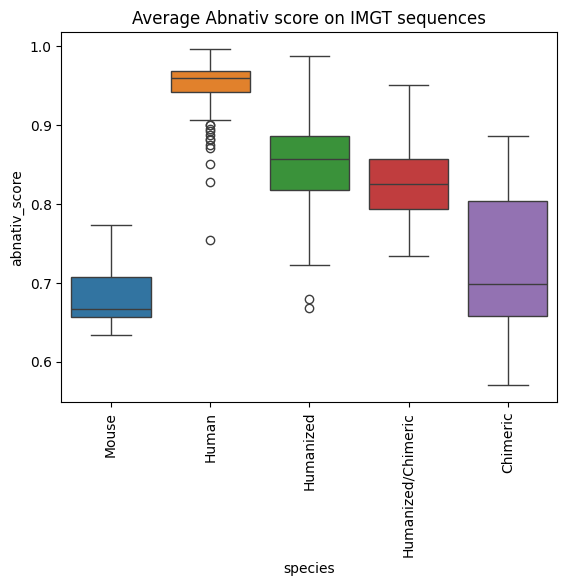

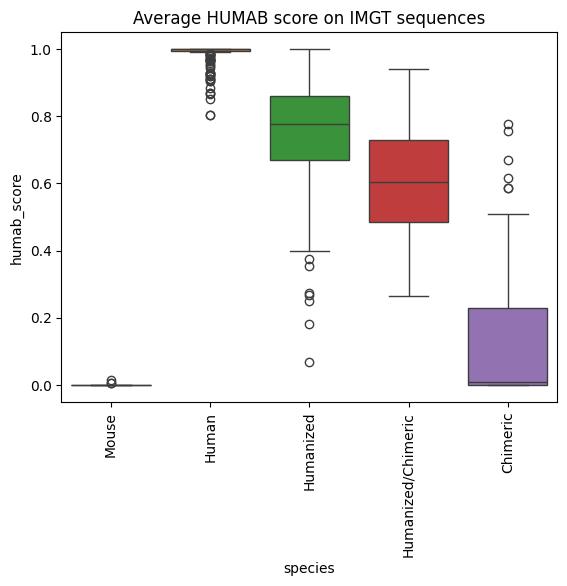

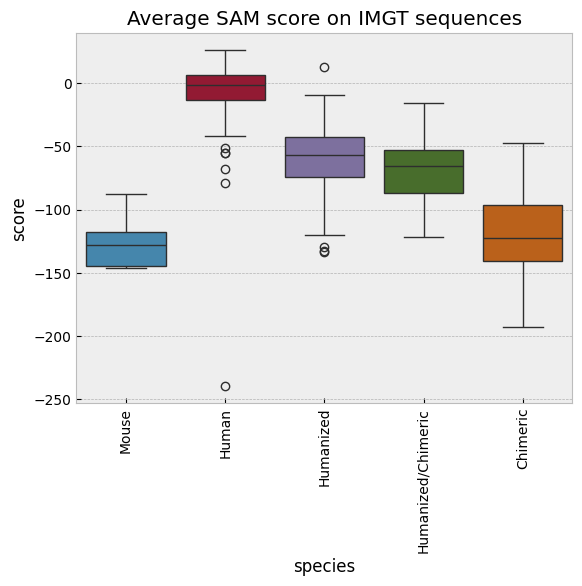

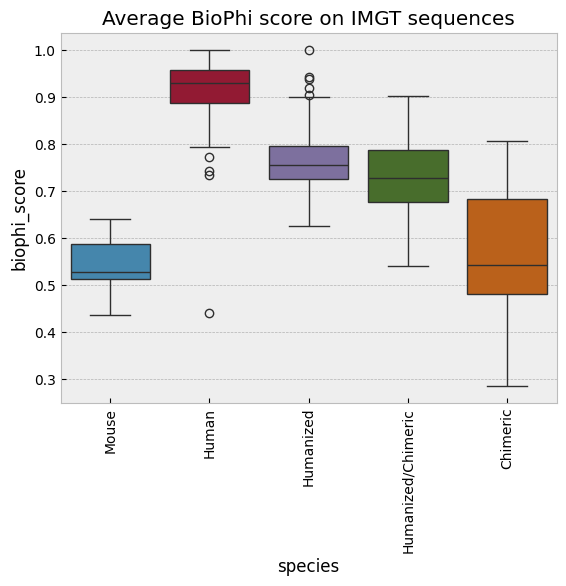

In [8]:
sns.boxplot(x="species", y="abnativ_score", data=score_match, hue="species")
plt.xticks(rotation=90)
plt.title("Average Abnativ score on IMGT sequences")
plt.show()

sns.boxplot(x="species", y="humab_score", data=score_match, hue="species")
plt.xticks(rotation=90)
plt.title("Average HUMAB score on IMGT sequences")
plt.show()

plt.style.use("bmh")
sns.boxplot(x="species", y="score", data=score_match, hue="species")
plt.xticks(rotation=90)
plt.title("Average SAM score on IMGT sequences")
plt.show()

sns.boxplot(x="species", y="biophi_score", data=score_match, hue="species")
plt.xticks(rotation=90)
plt.title("Average BioPhi score on IMGT sequences")
plt.show()

In [9]:
rng = np.random.default_rng(123)

for score_group in ["abnativ_score", "score", "humab_score", "biophi_score", "no_cdr_score"]:
    auc_values, prc_auc_values = [], []
    gt_scores = score_match["simple_species"].values
    input_scores = score_match[score_group].values
    print(score_group)

    for i in range(1000):
        idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
        auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
        precision, recall, thresholds = precision_recall_curve(gt_scores[idx], input_scores[idx])
        prc_auc_values.append(auc(recall, precision))
    
    auc_values = np.sort(np.array(auc_values))
    prc_auc_values = np.sort(np.array(prc_auc_values))
    print(f"AUC-ROC, LCB: {auc_values[25]}\nUCB: {auc_values[975]}")
    print(f"AUC-PRC, LCB: {prc_auc_values[25]}\nUCB: {prc_auc_values[975]}")
    precision, recall, thresholds = precision_recall_curve(gt_scores, input_scores)
    print(f"AUC-PRC: {auc(recall, precision)}")
    print(f"AUC-ROC: {roc_auc_score(gt_scores, input_scores)}")
    print("\n")

abnativ_score
AUC-ROC, LCB: 0.9609183809679189
UCB: 0.987284041827688
AUC-PRC, LCB: 0.9056498451369879
UCB: 0.9812837903977814
AUC-PRC: 0.9512913623249389
AUC-ROC: 0.9756086880364337


score
AUC-ROC, LCB: 0.9513202388661054
UCB: 0.983535655641567
AUC-PRC, LCB: 0.9225435084378681
UCB: 0.9761194660735294
AUC-PRC: 0.9539545180557092
AUC-ROC: 0.968675191218544


humab_score
AUC-ROC, LCB: 0.9614171511627906
UCB: 0.9846149467002547
AUC-PRC, LCB: 0.9213995280485825
UCB: 0.9720880520271722
AUC-PRC: 0.9478572736265964
AUC-ROC: 0.9735870263326911


biophi_score
AUC-ROC, LCB: 0.9523716839677047
UCB: 0.9843785289467741
AUC-PRC, LCB: 0.8913965165110818
UCB: 0.9748972499002199
AUC-PRC: 0.9376301263724877
AUC-ROC: 0.9709522975418928


no_cdr_score
AUC-ROC, LCB: 0.9573956740222853
UCB: 0.9858369529379721
AUC-PRC, LCB: 0.9450887997839458
UCB: 0.9789692729574724
AUC-PRC: 0.9631779198027985
AUC-ROC: 0.9726309336135927




SignificanceResult(statistic=0.965484121343293, pvalue=7.6438e-319)


Text(0, 0.5, 'SAM score')

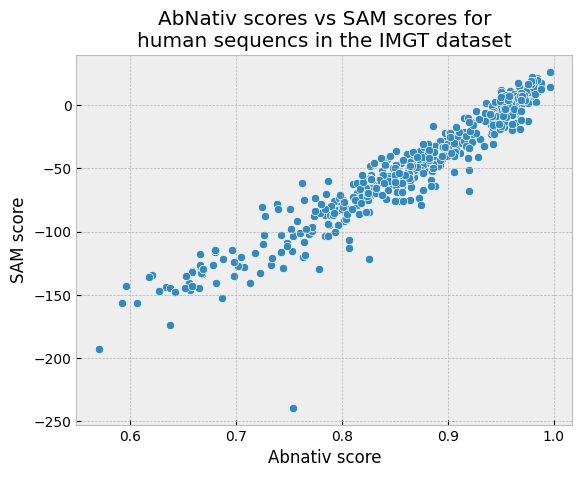

In [10]:
from scipy.stats import pearsonr
sns.scatterplot(x="abnativ_score", y="score", data=score_match)
from scipy.stats import spearmanr
print(spearmanr(score_match["abnativ_score"].values, score_match["score"].values))
plt.title("AbNativ scores vs SAM scores for\nhuman sequencs in the IMGT dataset")
plt.xlabel("Abnativ score")
plt.ylabel("SAM score")

SignificanceResult(statistic=0.927482592393987, pvalue=9.540603320410833e-234)


Text(0, 0.5, 'SAM score')

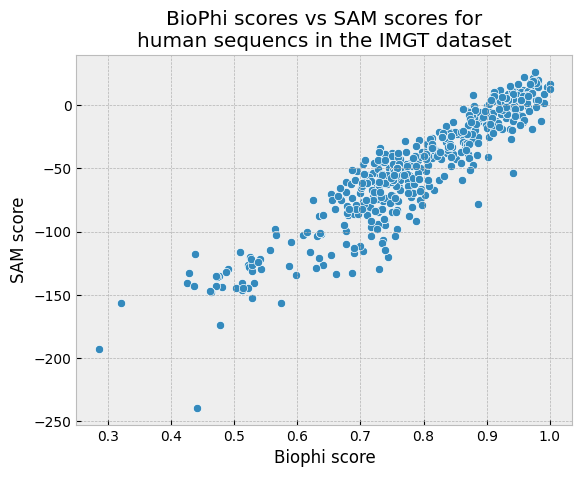

In [11]:
from scipy.stats import pearsonr
sns.scatterplot(x="biophi_score", y="score", data=score_match)
from scipy.stats import spearmanr
print(spearmanr(score_match["biophi_score"].values, score_match["score"].values))
plt.title("BioPhi scores vs SAM scores for\nhuman sequencs in the IMGT dataset")
plt.xlabel("Biophi score")
plt.ylabel("SAM score")